## ¿Qué características de una canción de pop determinan su popularidad?

##### Instrucción 1

##### Introducción:
Para este proyecto se utilizará la base de datos **Spotify Tracks Dataset** del autor Maharshi Pandya, la cual se encuentra disponible en este [link](https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset/data). De acuerdo con su descripción, el conjunto de datos incluye canciones de aproximadamente 125 géneros musicales, junto con diversas características relacionadas con sus propiedades de audio. El objetivo de este proyecto es determinar la **popularidad de una canción de pop** a partir de dichas características.

Antes de comenzar con cualquier análisis, primero se cargó la base de datos y se eliminaron las siguientes variables, ya que no aportaban información valiosa al análisis:

- **Unnamed: 0** → funge como numeración de los datos  
- **track_id** → clave para identificar la canción en Spotify  
- **artists** → artista o artistas que interpretan la canción  
- **album_name** → nombre del álbum donde se encuentra la canción  
- **track_name** → nombre de la canción  

Si bien estas variables son importantes para tener un dataset más completo, no agregan relevancia al análisis, ya que el objetivo es encontrar la relación entre la popularidad y las características propias de las canciones (propiedades de audio).

In [1]:
import pandas as pd
import numpy as np
import mlxtend.feature_selection as mlx
import sklearn.linear_model as sk
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from seaborn import heatmap
%matplotlib inline
df = pd.read_csv("spotifydataset.csv")
print("Dimensiones del data frame (inicial): ", df.shape)
print("\nColumnas (incial):\n", df.columns.tolist())
df = df.drop(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name'], axis=1)
print("\nColumnas (final):\n", df.columns.tolist())
print("\nTipos de variables:\n",df.dtypes)

Dimensiones del data frame (inicial):  (114000, 21)

Columnas (incial):
 ['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre']

Columnas (final):
 ['popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre']

Tipos de variables:
 popularity            int64
duration_ms           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_s

Una vez retiradas las variables anteriores, las características que se estarán utilizando para la generación de los modelos son las siguientes:

- **popularity** → Popularidad de la canción, medida del 0 al 100 (100 es lo más popular). Se calcula mediante un algoritmo que considera principalmente el número total de reproducciones y qué tan recientes han sido dichas reproducciones. (Respuesta de interés)
- **duration_ms** → Duración de la canción en milisegundos.
- **explicit** → Indica si la canción contiene letra explícita (`true` = sí, `false` = no).
- **danceability** → Mide qué tan bailable es una canción (0.0 a 1.0) considerando elementos como tempo, estabilidad del ritmo, fuerza del beat y regularidad general.
- **energy** → Nivel de energía de la canción (0.0 a 1.0). Representa intensidad y actividad perceptual. 
- **key** → Tono de la canción representado como un número entero. Ejemplo: 0 = C, 1 = C♯/D♭, 2 = D, etc.
- **loudness** → Nivel general de volumen de la canción en decibeles (dB).
- **mode** → Indica la modalidad de la canción: mayor (`1`) o menor (`0`).
- **speechiness** → Detecta la presencia de palabras habladas en una canción (0.0 a 1.0).    
- **acousticness** → Confianza (0.0 a 1.0) de que una canción es acústica. Un valor cercano a 1 indica alta probabilidad de serlo.
- **instrumentalness** → Predice si una canción carece de voces (0.0 a 1.0). Valores cercanos a 1 sugieren que la canción es instrumental.
- **liveness** → Estima la presencia de audiencia en la grabación (0.0 a 1.0). Valores superiores a 0.8 indican fuerte probabilidad de que sea una interpretación en vivo.
- **valence** → Mide la positividad emocional de la canción (0.0 a 1.0). Valores altos reflejan emociones positivas (felicidad, euforia), mientras que valores bajos reflejan emociones negativas (tristeza, enojo).
- **tempo** → Tempo estimado de la canción en beats per minute (BPM).
- **time_signature** → Compás estimado de la canción, es decir, cuántos tiempos hay en cada barra. Toma valores enteros entre 3 y 7 (ej. 3/4, 4/4, 7/4).
- **track_genre** → Género musical al que pertenece la canción.
(Pandya, 2022)

Considero que una regresión lineal podría funcionar como punto de partida, ya que es un modelo sencillo pero útil para identificar relaciones iniciales entre variables. En este caso, el dataset cuenta con varias características numéricas que podrían influir en la popularidad de una canción, lo cual permite aplicar una regresión lineal múltiple.

Si bien la regresión lineal puede resultar simple y no capturar relaciones no lineales o más complejas, es una buena primera aproximación porque facilita la interpretación de los resultados y nos brinda una base sólida para, en caso de ser necesario, comparar y evaluar el desempeño frente a modelos más avanzados.


##### Instrucción 2
Ya con la base de datos cargada, es necesario realizar modificaciones para poder aplicar los modelos. En este primer paso se generaron **variables dummy** para `track_genre` y `key`, ya que ambas son variables categóricas y no pueden ser utilizadas directamente.  

El siguiente fragmento de código divide cada categoría en variables independientes y elimina la variable original:


In [2]:
print("\nColumnas (antes):\n", df.columns.tolist())
# Generar dummies para track_genre
genre_dummies = pd.get_dummies(df['track_genre'], prefix='genre')
df = pd.concat([df, genre_dummies], axis=1)
df = df.drop('track_genre', axis=1)
print("Variables generadas (genre):", genre_dummies.shape[1])

# Generar variables dummies para key
key_dummies = pd.get_dummies(df['key'], prefix='key')
df = pd.concat([df, key_dummies], axis=1)
df = df.drop('key', axis=1)
print("\nColumnas (después):\n", df.columns.tolist())
print("Variables generadas (key):", key_dummies.shape[1])


Columnas (antes):
 ['popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre']
Variables generadas (genre): 114

Columnas (después):
 ['popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'genre_acoustic', 'genre_afrobeat', 'genre_alt-rock', 'genre_alternative', 'genre_ambient', 'genre_anime', 'genre_black-metal', 'genre_bluegrass', 'genre_blues', 'genre_brazil', 'genre_breakbeat', 'genre_british', 'genre_cantopop', 'genre_chicago-house', 'genre_children', 'genre_chill', 'genre_classical', 'genre_club', 'genre_comedy', 'genre_country', 'genre_dance', 'genre_dancehall', 'genre_death-metal', 'genre_deep-house', 'genre_detroit-techno', 'genre_disco', 'genre_disney', 'genre_drum-and-bass', 'genre_dub', 'genr

Como se puede observar, después de aplicar las variables dummy se generaron 114 nuevas variables de género musical y 12 para las notas. Comparar 114 géneros distintos podría generar mucha dispersión en los datos; por ello, se decidió que el modelo se concentrara únicamente en el género pop y sus subgéneros. Es decir, si un género contiene el término 'pop', será incluido en la base de datos.

En el siguiente fragmento de código se conservan únicamente las variables y los datos relacionados con pop, mientras que los demás géneros se eliminan del dataset. Posteriormente, se elimina la variable de género, ya que todos los datos corresponden a este género específico. Aunque esta decisión reduce significativamente la cantidad de datos disponibles, permite enfocar el análisis en un género particular, facilitando la interpretación y la consistencia del modelo.

In [3]:
# Limitar base de datos canciones de pop
pop_columns = [col for col in df.columns if col.startswith('genre') and 'pop' in col.lower()]
print("Géneros de pop válidos:", pop_columns)
mask = df[pop_columns].any(axis=1)
df = df[mask].reset_index(drop=True)
genre_columns = [col for col in df.columns if col.startswith('genre_')]
df = df.drop(columns=genre_columns)
print("\nColumnas (sin genre):\n", df.columns.tolist())
print("Dimensiones del data frame (sin genre): ", df.shape)

Géneros de pop válidos: ['genre_cantopop', 'genre_indie-pop', 'genre_j-pop', 'genre_k-pop', 'genre_mandopop', 'genre_pop', 'genre_pop-film', 'genre_power-pop', 'genre_synth-pop']

Columnas (sin genre):
 ['popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'key_0', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11']
Dimensiones del data frame (sin genre):  (9000, 26)


A continuación, se convertirán las variables con valores True y False a 1 y 0. Esto se realizará utilizando el tipo de dato int8, que permite representar valores binarios de manera eficiente.

Este procedimiento se aplicará a la variable explicit y a las múltiples variables de key generadas previamente mediante la función get_dummies.

In [4]:
print("Dataframe antes: ",df.head(10))
# Volver True = 1 y False = 0
# Explicit
df['explicit'] = df['explicit'].astype('int8')

# Keys
key_cols = [col for col in df.columns if col.startswith('key_')]
for col in key_cols:
    df[col] = df[col].astype('int8')
print("Dataframe después: ",df.head(10))

Dataframe antes:     popularity  duration_ms  explicit  danceability  energy  loudness  mode  \
0          47       183968     False         0.576   0.505   -13.070     0   
1          44       172343     False         0.577   0.228   -14.684     1   
2          50       191308     False         0.641   0.479   -15.395     1   
3          48       148564     False         0.613   0.210   -15.309     1   
4          54       228973     False         0.646   0.370   -10.980     1   
5          46       163775     False         0.453   0.380   -13.896     1   
6          42       206825     False         0.544   0.389    -9.989     1   
7          42       159596     False         0.472   0.344    -8.849     1   
8          41       126211     False         0.569   0.261   -13.836     1   
9          66       223950     False         0.679   0.563    -7.009     1   

   speechiness  acousticness  instrumentalness  ...  key_2  key_3  key_4  \
0       0.0392         0.753          0.199000 

A continuación, se revisarán los outliers del DataFrame en cuanto a la variable duration_ms utilizando el método de Tukey con k=3. Este método permite identificar valores que se encuentran muy por debajo o muy por encima del rango típico de los datos.

Posteriormente, tras analizar los datos, se decidió limitar la duración de las canciones a un mínimo de 1 minuto (60,000 ms) y un máximo de 10 minutos (600,000 ms). Aunque este rango no es extremadamente restrictivo, se mantiene amplio, ya que es relevante considerar si la popularidad de una canción está relacionada con su duración.

In [5]:
# Revisar outliers en duración
print("Dimensiones del data frame (antes): ", df.shape)
q1=df.duration_ms.quantile(0.25)
q3=df.duration_ms.quantile(0.75)
iqr=q3-q1
li=q1-(3*iqr)
ls=q3+(3*iqr)
out=np.where((df.duration_ms<=li) | (df.duration_ms>=ls))[0]
print("Outliers de duración:")
print(df.iloc[out])

# Limitar la duración de canciones entre 60,000 (1 min) - 600,000 (10 min)
df = df[(df['duration_ms'] >= 60000) & (df['duration_ms'] <= 600000)].copy()
df = df.reset_index(drop=True)
print("Dimensiones del data frame (después): ", df.shape)

Dimensiones del data frame (antes):  (9000, 26)
Outliers de duración:
      popularity  duration_ms  explicit  danceability  energy  loudness  mode  \
568           48       758307         0         0.437   0.473    -7.669     1   
689           40       601144         0         0.269   0.338   -12.757     1   
1663          40       548571         0         0.559   0.427   -12.228     1   
2008          66       537653         0         0.372   0.426    -8.421     1   
2992          36       605100         0         0.329   0.410   -11.870     1   
3256          13       946552         0         0.364   0.194   -14.938     1   
3325          54       541346         0         0.403   0.439   -15.154     0   
3468          52       519360         0         0.656   0.810    -7.448     1   
3475          53      3340672         0         0.719   0.466    -9.153     1   
3551          66       537653         0         0.372   0.426    -8.421     1   
3553          49      1613160         0

En el siguiente fragmento de código se revisa la colinealidad entre las variables. Cuando dos variables de entrada presentan un factor de colinealidad alto, se puede eliminar una de ellas, ya que indica que tienen aproximadamente el mismo efecto en el modelo.

En este caso, se encontró un factor de colinealidad de 0.7164 entre energy y loudness, lo cual tiene sentido debido a la descripción de las variables. Por esta razón, se decidió eliminar la variable loudness.

Dimensiones del data frame (antes):  (8972, 26)
Variables con mayor correlación (índices):  4 5
Variables con mayor correlación (nombre):  energy loudness
Valor de correlación absoluta:  0.7164419645798122


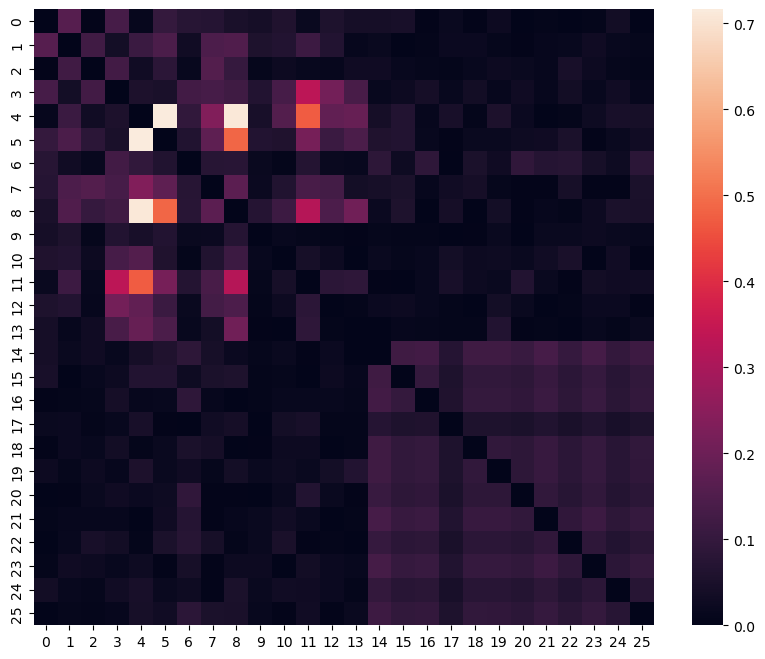

Dimensiones del data frame (después):  (8972, 25)


In [6]:
# Búsqueda de variables con corelación
print("Dimensiones del data frame (antes): ", df.shape)
cor=abs(np.corrcoef(df,rowvar=False))
np.fill_diagonal(cor,0)
i,j=np.unravel_index(cor.argmax(),cor.shape)
print("Variables con mayor correlación (índices): ",i,j)
print("Variables con mayor correlación (nombre): ", df.columns[i], df.columns[j])
print("Valor de correlación absoluta: ",cor[i,j])
plt.figure(figsize=(10, 8))
heatmap(cor)
plt.show()
df = df.drop('loudness', axis=1)
print("Dimensiones del data frame (después): ", df.shape)

##### Instrucción 3

En el siguiente fragmento de código se implementó una metodología mixta de selección de características, combinando los métodos hacia adelante y hacia atrás, con el objetivo de identificar las variables que realmente afectan la popularidad de las canciones. Primero, se dividió el dataset en conjuntos de entrenamiento y prueba (80/20) separando las variables independientes X de la variable dependiente Y (popularity) y se imprimieron los nombres de las características antes del proceso. Posteriormente, se aplicó la selección hacia adelante (forward) para agregar gradualmente variables significativas, y con las variables obtenidas se realizó la selección hacia atrás (backward) para eliminar redundancias y refinar la selección.

In [7]:
train, test = train_test_split(df, train_size = 0.8)
X_train = train.drop('popularity', axis=1)
Y_train = train['popularity']
X_test = test.drop('popularity', axis=1)
Y_test = test['popularity']
print("Características antes de selección: ",X_train.columns.tolist())
sfs_forward = mlx.SequentialFeatureSelector(estimator=sk.LinearRegression(), k_features=(2,8), forward=True, scoring='r2', cv=10)
sfs_forward.fit(X_train, Y_train)
print("Características seleccionadas forward (índices):", sfs_forward.k_feature_idx_)
print("Características seleccionadas forward (nombres):", sfs_forward.k_feature_names_)
X_train_forward = X_train[list(sfs_forward.k_feature_names_)]
X_test_forward = X_test[list(sfs_forward.k_feature_names_)]
sfs_backward = mlx.SequentialFeatureSelector(estimator=sk.LinearRegression(), k_features=(2,5), forward=False, scoring='r2', cv=10)
sfs_backward.fit(X_train_forward, Y_train)
print("Características seleccionadas forward+backward (índices):", sfs_backward.k_feature_idx_)
print("Características seleccionadas forward+backward (nombres):", sfs_backward.k_feature_names_)
X_train_backward = X_train[list(sfs_backward.k_feature_names_)]
X_test_backward = X_test[list(sfs_backward.k_feature_names_)]

Características antes de selección:  ['duration_ms', 'explicit', 'danceability', 'energy', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'key_0', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11']
Características seleccionadas forward (índices): (0, 2, 3, 4, 5, 6, 8, 9)
Características seleccionadas forward (nombres): ('duration_ms', 'danceability', 'energy', 'mode', 'speechiness', 'acousticness', 'liveness', 'valence')
Características seleccionadas forward+backward (índices): (0, 1, 2, 5, 7)
Características seleccionadas forward+backward (nombres): ('duration_ms', 'danceability', 'energy', 'acousticness', 'valence')


Esta metodología mixta fue utilizada porque el proceso hacia adelante permite identificar rápidamente variables importantes, mientras que el método hacia atrás ayuda a limpiar posibles redundancias; combinarlos asegura un proceso eficiente. Como conclusión, se observó que más que los tonos de las canciones, son características como la energía, la duración y otras cracterísticas musicales las que realmente influyen en la popularidad de una canción de pop y sus variantes.

##### Instrucción 4

Ya con la selección de características finalizada, se procedió a construir dos modelos distintos para predecir la variable de interés popularity.

El primer modelo corresponde a una regresión lineal multivariable, utilizando todas las variables seleccionadas previamente en X_train_backward. Este modelo se ajustó con la función OLS, lo que permitió imprimir un resumen completo de los coeficientes, su significancia , etc. Posteriormente, se calcularon las predicciones (yHat_ml) sobre el conjunto de prueba X_test_backward utilizando la función predict. 

Para el segundo modelo, se optó por un modelo cuadrático (no lineal), utilizando únicamente la variable energy, que también fue seleccionada en el proceso previo. La decisión de usar una sola variable y un polinomio de grado 2 se basó en mantener la interpretabilidad del modelo, ya que al agregar más variables o un grado polinómico mayor la interpretación de los coeficientes se vuelve más compleja. En este caso, energy se separó de los conjuntos de entrenamiento y prueba, se transformó a un array mediante reshape para poder ser usado por PolynomialFeatures, y se generó la matriz de características polinómicas de grado 2. El modelo se ajustó nuevamente con OLS y se calcularon las predicciones (yHat_mp) sobre los datos de prueba transformados.

Finalmente, se generó un gráfico comparativo donde en el eje X se representa la popularidad real y en el eje Y la popularidad predicha por ambos modelos. Este gráfico permite visualizar cómo se ajustan las predicciones a los valores reales, donde una tendencia lineal cercana a la diagonal indica una buena relación entre predicción y realidad. 


REGRESIÓN MULTILINEAL

                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     85.76
Date:                Sun, 07 Sep 2025   Prob (F-statistic):           8.05e-88
Time:                        22:51:39   Log-Likelihood:                -32462.
No. Observations:                7177   AIC:                         6.494e+04
Df Residuals:                    7171   BIC:                         6.498e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.9493 

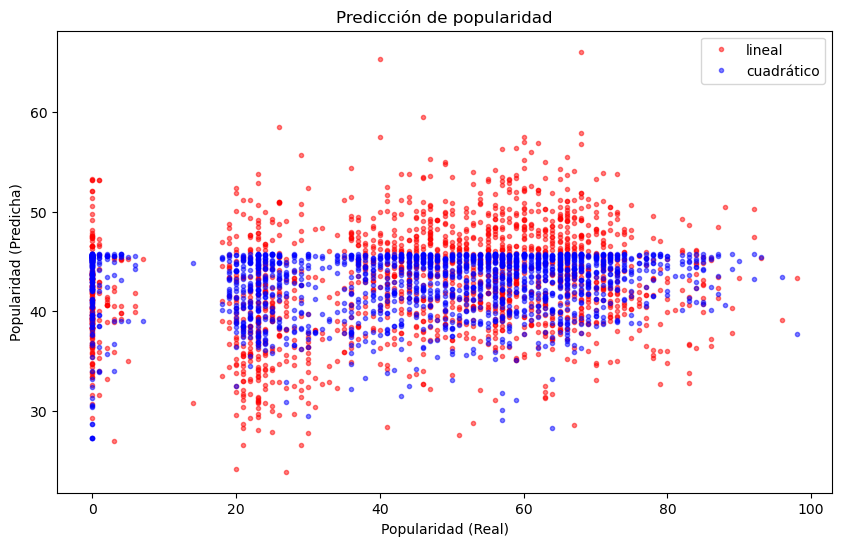

In [12]:
# Modelo lineal
model_l = sm.OLS(Y_train, sm.add_constant(X_train_backward)).fit()
print("\nREGRESIÓN MULTILINEAL\n")
print(model_l.summary())
yHat_ml = model_l.predict(sm.add_constant(X_test_backward))


# Modelo cuadrático
X_train_int = X_train_backward[['energy']]
X_test_int = X_test_backward[['energy']] 
X_train_r = X_train_int.values.reshape(-1, 1)  
X_test_r = X_test_int.values.reshape(-1, 1)  
X_train_poly = PolynomialFeatures(degree=2).fit_transform(X_train_r)
X_test_poly = PolynomialFeatures(degree=2).fit_transform(X_test_r)
model_p = sm.OLS(Y_train, X_train_poly).fit()
print("\nREGRESIÓN CUADRÁTICA\n")
print(model_p.summary())
yHat_mp = model_p.predict(X_test_poly)

# Gráfica
plt.figure(figsize=(10, 6))
plt.plot(Y_test, yHat_ml, "r.", label="lineal", alpha=0.5)
plt.plot(Y_test, yHat_mp, "b.", label="cuadrático", alpha=0.5)
plt.title("Predicción de popularidad")
plt.xlabel("Popularidad (Real)")
plt.ylabel("Popularidad (Predicha)")
plt.legend()
plt.show()

Como se puede observar en los resultados, todas las variables tanto del modelo lineal como del modelo cuadrático presentan un p-value menor a 0.05, lo que indica que tienen significancia estadística. Es decir, cada variable está asociada con la variable de salida (popularidad) con un nivel de confianza mínimo del 95%.

En el modelo lineal, por ejemplo, la variable danceability tiene un coeficiente de 28.026, lo que indica que, manteniendo constantes las demás variables, un aumento unitario en danceability se asocia con un incremento aproximado de entre 24.24 y 32.28 unidades en la popularidad de la canción. Esto sugiere que la bailabilidad de una canción tiene un efecto positivo considerable sobre su popularidad dentro del conjunto de canciones analizado.

En el modelo cuadrático con la variable energy, los coeficientes son x1 = 77.07 y x2 = -63.32, correspondientes a los términos lineal y cuadrático del polinomio. Esto indica que la relación entre la energía y la popularidad no es lineal: inicialmente, un aumento en energía incrementa la popularidad, pero a partir de cierto nivel, el efecto disminuye debido al término cuadrático negativo.

Sin embargo, al analizar el R², se observa que ambos modelos explican solo una pequeña proporción de la variabilidad de la popularidad. El modelo lineal tiene un R² de 0.056, lo que significa que explica únicamente el 5.6% de la variabilidad, mientras que el modelo cuadrático tiene un R² de 0.018, explicando apenas el 1.8% de la variabilidad. Esto sugiere que, aunque las variables seleccionadas son estadísticamente significativas y muestran efectos claros sobre la popularidad, la mayor parte de la variación en la popularidad de las canciones no es capturada por estos modelos.

##### Instrucción 5

A continuación se utilizarán las fórmulas vistas en clase para el cálculo de RSE (como métrica de error) y R² (como métrica de nivel de linealidad) de ambos modelos en términos de los datos de prueba.

In [13]:
RSSTest_ml = sum((Y_test - yHat_ml)**2)
TSSTest_ml = sum((Y_test - np.mean(Y_test))**2)
nTest_ml = X_test_backward.shape[0]
mTest_ml = X_test_backward.shape[1]
RSETest_ml = np.sqrt(RSSTest_ml / (nTest_ml - mTest_ml - 1))
R2Test_ml = 1 - RSSTest_ml / TSSTest_ml

print("Modelo lineal:")
print("R² (test):", R2Test_ml)
print("RSE (test):", RSETest_ml)


RSSTest_mp = sum((Y_test - yHat_mp)**2)
TSSTest_mp = sum((Y_test - np.mean(Y_test))**2)
nTest_mp = X_test_poly.shape[0]
mTest_mp = X_test_poly.shape[1]
RSETest_mp = np.sqrt(RSSTest_mp / (nTest_mp - mTest_mp - 1))
R2Test_mp = 1 - RSSTest_mp / TSSTest_mp

print("\nModelo cuadrático:")
print("R² (test):", R2Test_mp)
print("RSE (test):", RSETest_mp)

Modelo lineal:
R² (test): 0.06102047963233925
RSE (test): 22.460070615193388

Modelo cuadrático:
R² (test): 0.01486406197814416
RSE (test): 22.99262286561159


Comenzando con el modelo lineal, se observa que el R² es muy bajo, con un valor de 0.06, lo que indica que este modelo explica únicamente el 6% de la variabilidad de los datos. En otras palabras, no describe de manera efectiva la dispersión de los puntos. Por otro lado, el RSE es de 22.46, lo que significa que, en promedio, las predicciones del modelo pueden desviarse aproximadamente ±22.46 unidades respecto a los valores reales de popularidad. Considerando que la escala de popularidad va de 1 a 100, esto representa un rango de error bastante amplio, lo que limita la precisión del modelo.

En cuanto al modelo cuadrático, se observa un comportamiento similar, con un R² de 0.015 y un RSE de 22.99. Esto indica que, al igual que el modelo lineal, el ajuste de los datos es pobre y el rango de error es amplio.

En conclusión, ninguno de los dos modelos logró un ajuste adecuado de los datos, tanto para el conjunto de entrenamiento como para el de prueba. Sin embargo, los análisis de significancia mostraron que las variables utilizadas son estadísticamente relevantes. **Por lo tanto, aunque los modelos actuales no capturan bien la variabilidad de la popularidad, las variables seleccionadas pueden mantenerse para futuras aproximaciones, considerando la posibilidad de aplicar modelos más complejos.**

##### Instrucción 6

A partir de los resultados obtenidos anteriormente, se puede concluir que el modelo de regresión multivariable presenta un R² ligeramente mayor (mejor desempeño del modelo), por lo que se trabajará con este para el análisis inferencial.

En este tipo de análisis no es necesario realizar una división entre train y test, por lo que se definió Y como la variable respuesta (popularity) y X como el conjunto del resto de variables. Posteriormente, se aplicó nuevamente el método de selección de variables mixto, pero ahora utilizando todos los datos y no solo los de train. 

Para un análisis inferencial, el objetivo es obtener la mejor estimación de la relación verdadera entre las variables en la población. Por lo tanto, es importante señalar que la selección de características podría introducir un optimismo leve en las métricas del modelo, pero el tener menos variables ayuda a la interpretabilidad de modelo.

Finalmente, se empleó la función OLS para construir el modelo, cuyos resultados se imprimieron con ayuda de la función summary.

In [16]:
X = df.drop('popularity', axis=1)
Y = df.popularity

print("Características antes de selección: ",X.columns.tolist())
sfs_forward = mlx.SequentialFeatureSelector(estimator=sk.LinearRegression(), k_features=(2,8), forward=True, scoring='r2', cv=10)
sfs_forward.fit(X, Y)
print("Características seleccionadas forward (índices):", sfs_forward.k_feature_idx_)
print("Características seleccionadas forward (nombres):", sfs_forward.k_feature_names_)
X_forward = X[list(sfs_forward.k_feature_names_)]
sfs_backward = mlx.SequentialFeatureSelector(estimator=sk.LinearRegression(), k_features=(2,5), forward=False, scoring='r2', cv=10)
sfs_backward.fit(X_forward, Y)
print("Características seleccionadas forward+backward (índices):", sfs_backward.k_feature_idx_)
print("Características seleccionadas forward+backward (nombres):", sfs_backward.k_feature_names_)
X_backward = X[list(sfs_backward.k_feature_names_)]


model_inf  = sm.OLS(Y, sm.add_constant(X_backward)).fit()
print(model_inf.summary())

Características antes de selección:  ['duration_ms', 'explicit', 'danceability', 'energy', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'key_0', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11']
Características seleccionadas forward (índices): (0, 2, 4, 5, 8, 12, 22)
Características seleccionadas forward (nombres): ('duration_ms', 'danceability', 'mode', 'speechiness', 'liveness', 'key_0', 'key_10')
Características seleccionadas forward+backward (índices): (0, 1, 2, 3, 4)
Características seleccionadas forward+backward (nombres): ('duration_ms', 'danceability', 'mode', 'speechiness', 'liveness')
                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-stat

A partir de los resultados del análisis inferencial mediante el modelo de regresión multivariable, se observa que el R² obtenido es de 0.055, lo que indica que el modelo explica únicamente el 5.5% de la variabilidad en los datos.

Sin embargo, al analizar los p-values de las variables, se aprecia que son menores a 0.05, lo cual permite concluir, con un 95% de confianza, que estas variables son estadísticamente significativas.

En cuanto a los coeficientes, destaca el valor de danceability, con un estimado de 19.56. Esto significa que un incremento de una unidad en danceability se asocia con un aumento aproximado de entre 16.13 y 22.98 unidades en la popularidad de la canción.

##### Conclusión general

A manera de conclusión, se puede decir que ninguno de los modelos, ya fueran predictivos o inferenciales, logró describir adecuadamente la variabilidad de los datos, pues los valores de R² fueron demasiado bajos. Esto indica que el ajuste de la línea a los datos no fue bueno.

No obstante, en todos los modelos se observó que las variables seleccionadas resultaron estadísticamente significativas al 95% de confianza (p-value < 0.05). Esto significa que, aunque el modelo en su conjunto no explica bien la popularidad de las canciones, algunas características individuales sí influyen de manera relevante en la respuesta.

En conclusión, los modelos revisados en clase no son lo suficientemente complejos como para capturar el comportamiento de los datos, pero las variables identificadas pueden servir como base para construir y probar modelos más robustos en el futuro.

##### Referencias
Pandya, M. (2022). Spotify Tracks Dataset. Kaggle. https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset/data.